# Part 1: Finding the most frequent trip using three different methods (DataFrames, Spark SQL, and RDDs)

**In this first part, we will implement and compare the efficiency of the three different methods covered in class. We will use data provided by the New York TLC (Taxi and Limousine Commission) and focus on the most frequently taken taxi trips over previous years.**

### Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from time import time
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.types import *

spark = SparkSession.builder.master('local[*]').getOrCreate()
#spark.conf.set('spark.cores.max', '1')
#spark.conf.set('spark.driver.memory','1000M')

sc = spark.sparkContext

spark

In [2]:
!pip install psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.1 gigabytes of available RAM



### A) DataFrames

In [3]:
#We define this files list to facilitate file selection
files = [
    "data/yellow_tripdata_2020-01.parquet",
    "data/yellow_tripdata_2020-02.parquet",
    "data/yellow_tripdata_2020-03.parquet",
    "data/yellow_tripdata_2020-04.parquet",
    "data/yellow_tripdata_2020-05.parquet",
    "data/yellow_tripdata_2020-06.parquet",
    "data/yellow_tripdata_2020-07.parquet",
    "data/yellow_tripdata_2020-08.parquet",
    "data/yellow_tripdata_2020-09.parquet",
    "data/yellow_tripdata_2020-10.parquet",
    "data/yellow_tripdata_2020-11.parquet",
    "data/yellow_tripdata_2020-12.parquet",
    
    "data/yellow_tripdata_2021-01.parquet",
    "data/yellow_tripdata_2021-02.parquet",
    "data/yellow_tripdata_2021-03.parquet",
    "data/yellow_tripdata_2021-04.parquet",
    "data/yellow_tripdata_2021-05.parquet",
    "data/yellow_tripdata_2021-06.parquet",
    "data/yellow_tripdata_2021-07.parquet",
    "data/yellow_tripdata_2021-08.parquet",
    "data/yellow_tripdata_2021-09.parquet",
    "data/yellow_tripdata_2021-10.parquet",
    "data/yellow_tripdata_2021-11.parquet",
    "data/yellow_tripdata_2021-12.parquet",

    "data/yellow_tripdata_2022-01.parquet",
    "data/yellow_tripdata_2022-02.parquet",
    "data/yellow_tripdata_2022-03.parquet",
    "data/yellow_tripdata_2022-04.parquet",
    "data/yellow_tripdata_2022-05.parquet",
    "data/yellow_tripdata_2022-06.parquet",
    "data/yellow_tripdata_2022-07.parquet",
    "data/yellow_tripdata_2022-08.parquet",
    "data/yellow_tripdata_2022-09.parquet",
    "data/yellow_tripdata_2022-10.parquet",
    "data/yellow_tripdata_2022-11.parquet",
    "data/yellow_tripdata_2022-12.parquet",

    "data/yellow_tripdata_2019-01.parquet",
    "data/yellow_tripdata_2019-02.parquet",
    "data/yellow_tripdata_2019-03.parquet",
    "data/yellow_tripdata_2019-04.parquet",
    "data/yellow_tripdata_2019-05.parquet",
    "data/yellow_tripdata_2019-06.parquet",
    "data/yellow_tripdata_2019-07.parquet",
    "data/yellow_tripdata_2019-08.parquet",
    "data/yellow_tripdata_2019-09.parquet",
    "data/yellow_tripdata_2019-10.parquet",
    "data/yellow_tripdata_2019-11.parquet",
    "data/yellow_tripdata_2019-12.parquet",


    "data/yellow_tripdata_2023-01.parquet",
    "data/yellow_tripdata_2023-02.parquet",
    "data/yellow_tripdata_2023-03.parquet",
    "data/yellow_tripdata_2023-04.parquet",
    "data/yellow_tripdata_2023-05.parquet",
    "data/yellow_tripdata_2023-06.parquet",
    "data/yellow_tripdata_2023-07.parquet",
    "data/yellow_tripdata_2023-08.parquet",
    "data/yellow_tripdata_2023-09.parquet",
    "data/yellow_tripdata_2023-10.parquet",
    "data/yellow_tripdata_2023-11.parquet",
    "data/yellow_tripdata_2023-12.parquet",
]

**For the first three parts, which involve performing the analysis using the three methods, we will focus on the data from 2020, 2021, and 2022. For the subsequent parts, which involve comparing the efficiency of each method, we will also include data from 2019 and 2023.**

In [4]:
selected_files = files[:36]

**Let's start by reading the data files**

In [5]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

In [6]:
df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

**Here is the structure of the tables we are using**

In [7]:
df1.printSchema()

root
 |-- LocationID: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Zone: string (nullable = true)
 |-- service_zone: string (nullable = true)



In [8]:
df2.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



**To make the analysis easier to understand, we will perform a double join between these two tables to associate the PickUp and DropOff zone IDs with their corresponding zone names.**

In [9]:
#Duplicate the ID/Zone mapping DataFrame to perform the double join
df1_pu = df1.withColumnRenamed("Zone", "PULocation")
df1_do = df1.withColumnRenamed("Zone", "DOLocation")

joined1 = df2.join(df1_pu, df2["PULocationID"] == df1_pu["LocationID"])

joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

In [10]:
joined.select("PULocation", "DOLocation").show(10)

+--------------------+--------------------+
|          PULocation|          DOLocation|
+--------------------+--------------------+
|Upper West Side N...|Upper West Side S...|
|Upper West Side S...|Upper West Side N...|
|Upper West Side N...|Upper West Side N...|
|Upper West Side N...|    Manhattan Valley|
|Queensbridge/Rave...|Queensbridge/Rave...|
|             Astoria|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|Queensbridge/Rave...|Queensbridge/Rave...|
|West Chelsea/Huds...|        Clinton East|
+--------------------+--------------------+
only showing top 10 rows


**Now, our "joined" DataFrame correctly lists the PickUp and DropOff zones with their corresponding names. The first 10 rows are displayed above.**

**Next, we will find the most frequent trips using "groupBy" followed by "count" and then "sort"**

In [11]:
grouped = joined.groupBy("PULocation", "DOLocation").count()

In [12]:
result = grouped.sort(grouped["count"].desc())

In [13]:
result.show(10)

+--------------------+--------------------+------+
|          PULocation|          DOLocation| count|
+--------------------+--------------------+------+
|Upper East Side S...|Upper East Side N...|658213|
|Upper East Side N...|Upper East Side S...|561283|
|Upper East Side N...|Upper East Side N...|459590|
|Upper East Side S...|Upper East Side S...|454100|
|                 N/A|                 N/A|419251|
|Upper West Side S...|Upper West Side N...|258792|
|Upper East Side S...|      Midtown Center|256545|
|Upper West Side S...| Lincoln Square East|252737|
|     Lenox Hill West|Upper East Side N...|244680|
| Lincoln Square East|Upper West Side S...|244298|
+--------------------+--------------------+------+
only showing top 10 rows


**Between 2020 and 2022, the most frequent trips were between the Upper East Side South and Upper East Side North zones in Manhattan.**

**We can now examine the evolution of these trips for each year to get a better overview.**

In [14]:
firsts = 5 #Focus on the 5 most popular trips each year

pu_lists = [[] for i in range(firsts)]
do_lists = [[] for i in range(firsts)]
counts_lists = [[] for i in range(firsts)]

for i in range(20, 23):
    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(f"data/yellow_tripdata_20{i}*.parquet")

    #Join
    df1_pu = df1.withColumnRenamed("Zone", "PULocation")
    df1_do = df1.withColumnRenamed("Zone", "DOLocation")
    joined1 = df2.join(df1_pu, df2["PULocationID"] == df1_pu["LocationID"])
    joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

    
    grouped = joined.groupBy("PULocation", "DOLocation").count()
    results = grouped.sort(grouped["count"].desc()).limit(5).collect()

    #Store the firsts 5 trips and their counts
    for rank in range(firsts):
        pu_lists[rank].append(results[rank]["PULocation"])
        do_lists[rank].append(results[rank]["DOLocation"])
        counts_lists[rank].append(results[rank]["count"])

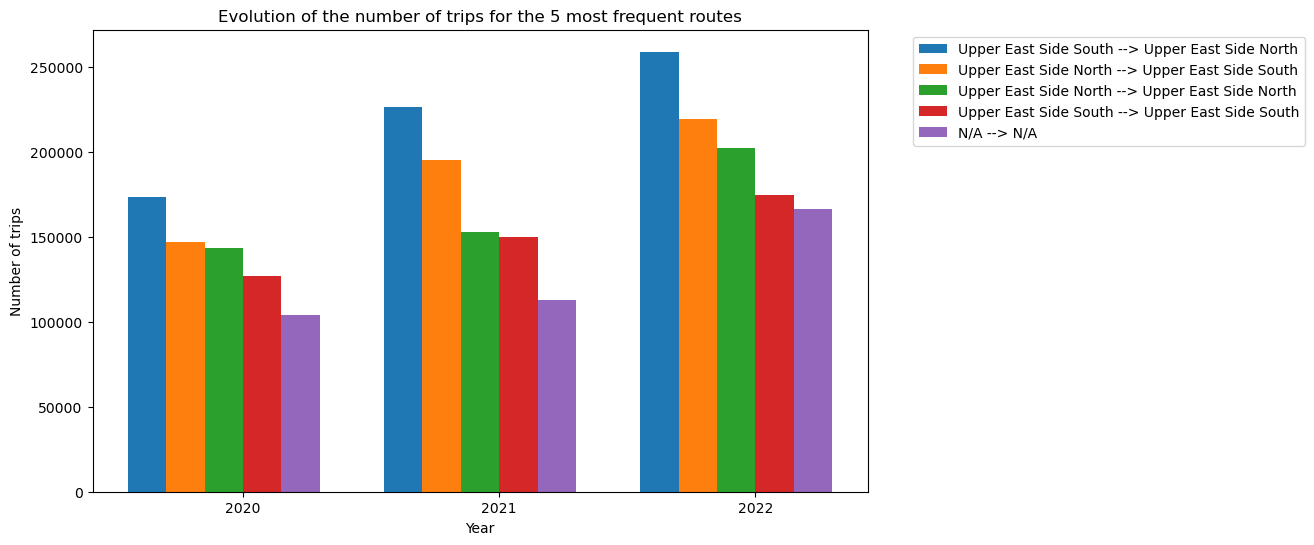

In [15]:
years = [2020, 2021, 2022]
x = np.array([i for i in range(len(years))]) #Offset for the shift
width = 0.15 


fig = plt.subplots(figsize=(10,6))

#Plot the bars for the firsts 5 trips
for i in range(firsts):
    plt.bar(x + (i - firsts/2) * width, counts_lists[i], width, label = pu_lists[i][0] + " --> " + do_lists[i][0])


plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.title('Evolution of the number of trips for the 5 most frequent routes')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(x, years)

plt.show()

**This chart confirms the overall trend. Over these three years, the trip from Upper East Side South --> Upper East Side North is the most frequent.**

**We also notice that the total number of trips increases each year. The lower count in 2020 is explained by the global COVID-19 crisis, followed by a gradual increase in subsequent years, reflecting a return to normal.**

### B) Spark SQL

**Let's start by reading the files**

In [16]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)

In [17]:
df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

**Next, let's create temporary views**

In [18]:
df1.createOrReplaceTempView("zones")
df2.createOrReplaceTempView("trips")

**Let's execute the corresponding SQL query**

In [19]:
results = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS trip_count FROM trips t
JOIN zones pu ON t.PULocationID = pu.LocationID
JOIN zones do ON t.DOLocationID = do.LocationID
GROUP BY pu.Zone, do.Zone
ORDER BY trip_count DESC
"""
)

In [20]:
results.show(10)

+--------------------+--------------------+----------+
|          PULocation|          DOLocation|trip_count|
+--------------------+--------------------+----------+
|Upper East Side S...|Upper East Side N...|    658213|
|Upper East Side N...|Upper East Side S...|    561283|
|Upper East Side N...|Upper East Side N...|    459590|
|Upper East Side S...|Upper East Side S...|    454100|
|                 N/A|                 N/A|    419251|
|Upper West Side S...|Upper West Side N...|    258792|
|Upper East Side S...|      Midtown Center|    256545|
|Upper West Side S...| Lincoln Square East|    252737|
|     Lenox Hill West|Upper East Side N...|    244680|
| Lincoln Square East|Upper West Side S...|    244298|
+--------------------+--------------------+----------+
only showing top 10 rows


**We obtain the same result as the previous method : between 2020 and 2022, the most frequent trips were between the Upper East Side South and Upper East Side North areas of Manhattan.**


**As before, let's look at the evolution of these trips over each year to get a better understanding.**

In [21]:
firsts = 5 #Focus on the 5 most popular trips each year

pu_lists = [[] for i in range(firsts)]
do_lists = [[] for i in range(firsts)]
c_lists = [[] for i in range(firsts)]


for i in range(20, 23):
    #Reading files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(f"data/yellow_tripdata_20{i}*.parquet")

    #Views
    df1.createOrReplaceTempView("zones")
    df2.createOrReplaceTempView("trips")

     
    results = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS count FROM trips t
    JOIN zones pu ON t.PULocationID = pu.LocationID
    JOIN zones do ON t.DOLocationID = do.LocationID
    GROUP BY pu.Zone, do.Zone
    ORDER BY count DESC
    LIMIT 5
    """).collect()
    
    #Store the firsts 5 trips and their counts
    for rank in range(firsts):
        pu_lists[rank].append(results[rank]["PULocation"])
        do_lists[rank].append(results[rank]["DOLocation"])
        c_lists[rank].append(results[rank]["count"])

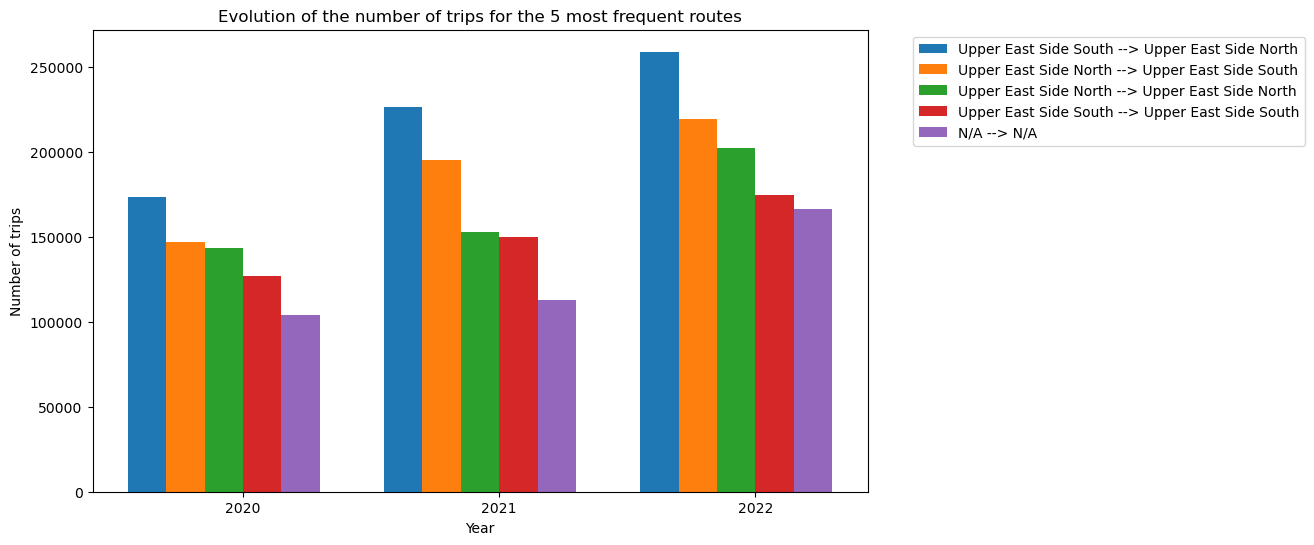

In [22]:
years = [2020, 2021, 2022]
x = np.array([i for i in range(len(years))]) #Offset for the shift
width = 0.15  

fig = plt.subplots(figsize=(10,6))

#Plot the bars for the firsts 5 trips
for i in range(firsts):
    plt.bar(x + (i - firsts/2) * width, c_lists[i], width, label = pu_lists[i][0] + " --> " + do_lists[i][0])


plt.xlabel('Year')
plt.ylabel('Number of trips')
plt.title('Evolution of the number of trips for the 5 most frequent routes')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(x, years)

plt.show()

**We obtain the same results. Using SQL queries or DataFrames is equivalent for this analysis.**

### C) RDDs

**For this part, we encountered difficulties in processing as much data as in the previous sections. As shown in the graph provided in the “Appendix,” the execution times increase very rapidly with the amount of data, which often led to Kernel crashes. This forced us to limit our analysis to 3 months of data instead of 3 years, although the underlying principle remains exactly the same.**

In [23]:
selected_files = files[:3] #We only select 3 months of data

**First, to prevent kernel crashes, we have to modify the Spark configuration**

In [24]:
conf = SparkConf().setMaster("local[*]").set("spark.driver.memory", "4g").set("spark.executor.memory", "4g").set("spark.driver.maxResultSize", "1g")  # limits how much data the driver can collect from executors to prevent a crash of the kernel


spark = SparkSession.builder.config(conf=conf).getOrCreate()
sc = spark.sparkContext

spark

**Since the data types of some columns vary depending on the year, we need to enforce a universal schema to avoid type conflicts, which are particularly problematic when working with RDDs.**

In [25]:
schema = StructType([
    StructField("VendorID", LongType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", DoubleType()),
    StructField("trip_distance", DoubleType()),
    StructField("RatecodeID", DoubleType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("PULocationID", LongType()),
    StructField("DOLocationID", LongType()),
    StructField("payment_type", LongType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType()),
    StructField("congestion_surcharge", DoubleType()),
    StructField("airport_fee", DoubleType())
])

In [26]:
df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
df2 = spark.read.format("parquet").schema(schema).option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

**Now, we transform the DataFrames into RDDs to prepare for key-value type operations.**

**- From df1, we extract for each record the pair (LocationID, Zone), which allows associating a location identifier with its zone name.**

**- From df2, we extract the pair (PULocationID, DOLocationID), useful for linking the pickup and drop-off locations of trips.**

In [27]:
rdd1 = df1.rdd.map(lambda x: (x['LocationID'], x['Zone']))
rdd2 = df2.rdd.map(lambda x: (x['PULocationID'], x['DOLocationID']))

In [28]:
#We duplicate rdd1, one to join the PickUp locations names, one to join the DropOut locations Names
pu = rdd1
do = rdd1

#Association of PULocationID with Zone_pickup
joined1 = rdd2.join(pu)  #We obtain this map (PULocationID, (DOLocationID, Zone_PU)). We have to re-map it to complete this first association

#Re-map (switching PULocationID with DOLocationID)
switched1 = joined1.map(lambda x: (x[1][0], (x[0], x[1][1]))) #We obtain this map (DOLocationID, (PULocationID, Zone_PU))



#Association of DOLocationID with Zone_pickup
joined2 = switched1.join(do) #We obtain this map (DOLocationID, ((PULocationID, Zone_PU), Zone_DO)

#Re-map to obtain ((Zone_PU, Zone_DO), 1)
joined = joined2.map(lambda x: ((x[1][0][1], x[1][1]), 1))

**We count the number of trips for each (Zone_PU, Zone_DO)**

In [29]:
counts = joined.reduceByKey(lambda a, b: a + b)

**Then we get the 5 most frequent**

In [30]:
results = counts.sortBy(lambda x: x[1], False).take(5)

In [31]:
for e in results:
    print(e)

(('Upper East Side South', 'Upper East Side North'), 106672)
(('Upper East Side North', 'Upper East Side North'), 93454)
(('Upper East Side North', 'Upper East Side South'), 90488)
(('Upper East Side South', 'Upper East Side South'), 81317)
(('N/A', 'N/A'), 64969)


**Of course, the results are not exactly the same since the input data are different, but this allows us to confirm that the trend observed over 3 years is consistent with that seen over 3 months : the most frequent trips were between the Upper East Side South and Upper East Side North areas of Manhattan.**

**As before, let's look at the evolution of these trips over each month to get a better understanding.**

In [33]:
firsts = 5 #Focus on the 5 most popular trips each year

pu_lists = [[] for i in range(firsts)]
do_lists = [[] for i in range(firsts)]
c_lists = [[] for i in range(firsts)]


for i in range(1, 4):
    #Reading files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").schema(schema).option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(f"data/yellow_tripdata_2020-0{i}*.parquet")



    #RDDs
    rdd1 = df1.rdd.map(lambda x: (x['LocationID'], x['Zone']))
    rdd2 = df2.rdd.map(lambda x: (x['PULocationID'], x['DOLocationID']))

    #Join
    pu = rdd1
    do = rdd1

    joined1 = rdd2.join(pu) 
    switched1 = joined1.map(lambda x: (x[1][0], (x[0], x[1][1])))
    joined2 = switched1.join(do) 

    joined = joined2.map(lambda x: ((x[1][0][1], x[1][1]), 1))


    #Count
    counts = joined.reduceByKey(lambda a, b: a + b)

    #Sort
    results = counts.sortBy(lambda x: x[1], False).take(5)
    
    
    #Store the firsts 5 trips and their counts
    for rank in range(firsts):
        pu_lists[rank].append(results[rank][0][0])
        do_lists[rank].append(results[rank][0][1])
        c_lists[rank].append(results[rank][1])

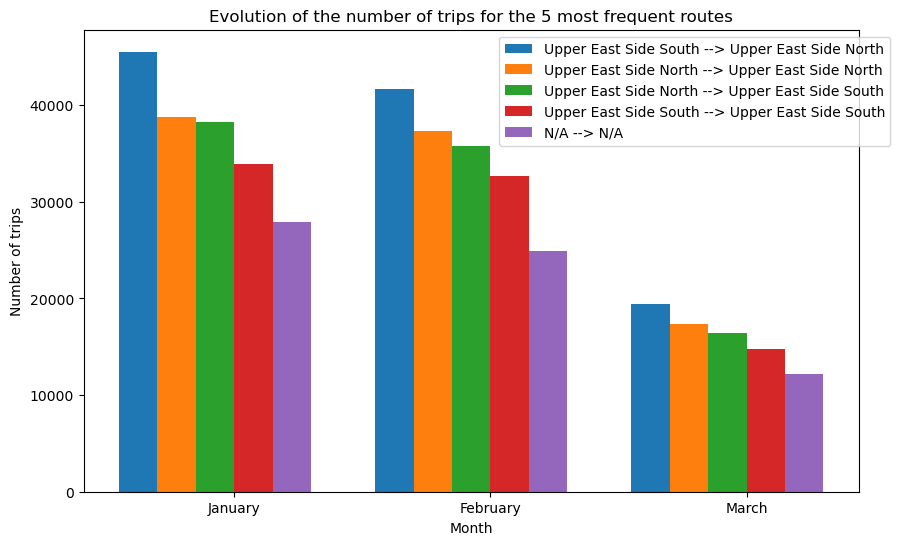

In [34]:
months = ["January", "February", "March"]
x = np.array([i for i in range(len(months))]) #Offset for the shift
width = 0.15  

fig = plt.subplots(figsize=(10,6))

#Plot the bars for the firsts 5 trips
for i in range(firsts):
    plt.bar(x + (i - firsts/2) * width, c_lists[i], width, label = pu_lists[i][0] + " --> " + do_lists[i][0])


plt.xlabel('Month')
plt.ylabel('Number of trips')
plt.title('Evolution of the number of trips for the 5 most frequent routes')

plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(x, months)

plt.show()

**Finally, we obtain the same trend over the months.** 



#### Appendix

**Let’s look at how the execution time evolves with respect to the number of data points.**

In [35]:
def RDD(n_months):

    selected_files = files[:n_months]

    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    rdd1 = df1.rdd.map(lambda x: (x['LocationID'], x['Zone']))
    df2 = spark.read.format("parquet").schema(schema).option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("mode", "DROPMALFORMED").load(selected_files)
    rdd2 = df2.rdd.map(lambda x: (x['PULocationID'], x['DOLocationID']))

    pu = rdd1
    do = rdd1

    joined1 = rdd2.join(pu) 
    switched1 = joined1.map(lambda x: (x[1][0], (x[0], x[1][1])))
    joined2 = switched1.join(do) 

    joined = joined2.map(lambda x: ((x[1][0][1], x[1][1]), 1))

    counts = joined.reduceByKey(lambda a, b: a + b)
    results = counts.sortBy(lambda x: x[1], False).take(5)

    return results
    

In [36]:
months = [i for i in range(0, 4)]
times = []

for i in months:
    t0_df = time()
    RDD(i)
    times.append(np.round(time() - t0_df, 3))

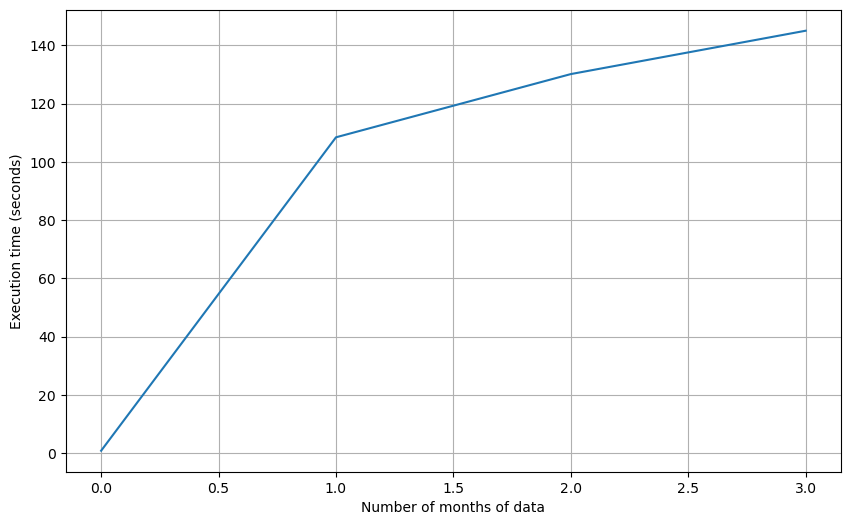

In [38]:
plt.figure(figsize=(10,6))

plt.plot(months, times)

plt.xlabel('Number of months of data')
plt.ylabel("Execution time (seconds)")
plt.grid(True)
plt.show()

**The graph shows that with only 3 months of data, the execution time already reaches more than 2 minutes. It also highlights a rapid increase in execution time, which would become excessively high if working with 3 years of data.**

### D) Comparison of the DataFrame and SQL methods

**In this section, we will compare the efficiency of the 2 methods.**

**To do this, we will record and compare execution times based on the amount of input data.**

**For each method, we define a corresponding function**

In [39]:
def dataFrame(n_months):

    #Select the number of months of data to process
    selected_files = files[:n_months]

    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

    #GroupBy
    count = df.groupBy("PULocationID", "DOLocationID").count()

    #Join
    df1_pu = df1.withColumnRenamed("Zone", "PULocation")
    df1_do = df1.withColumnRenamed("Zone", "DOLocation")

    joined1 = count.join(df1_pu, count["PULocationID"] == df1_pu["LocationID"])

    joined = joined1.join(df1_do, joined1["DOLocationID"] == df1_do["LocationID"])

    #Sort
    sort = joined.sort(count["count"].desc())
    

    #Select the columns
    result = sort.select("PULocation", "DOLocation", "count")

    return result
    

In [40]:
def SQL(n_months):

    #Select the number of months of data to process
    selected_files = files[:n_months]

    #Read the files
    df1 = spark.read.csv('taxi_zone_lookup.csv', header=True, inferSchema=True)
    df2 = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(selected_files)

    #Views creation
    df1.createOrReplaceTempView("zones")
    df2.createOrReplaceTempView("trips")

 
    result = spark.sql("""SELECT pu.Zone AS PULocation, do.Zone AS DOLocation, COUNT(*) AS count FROM trips t
    JOIN zones pu ON t.PULocationID = pu.LocationID
    JOIN zones do ON t.DOLocationID = do.LocationID
    GROUP BY pu.Zone, do.Zone
    ORDER BY count DESC
    """)

    return result
    

**First, let's look at the overall evolution of execution time as the amount of data processed increases.**

In [41]:
months = [i for i in range(1, 60, 2)]
times_df = []
times_sql = []

for i in months:
    #DataFrame time
    t0_df = time()
    dataFrame(i)
    times_df.append(np.round(time() - t0_df, 3))

    #SQL time
    t0_sql = time()
    SQL(i)
    times_sql.append(np.round(time() - t0_sql, 3))

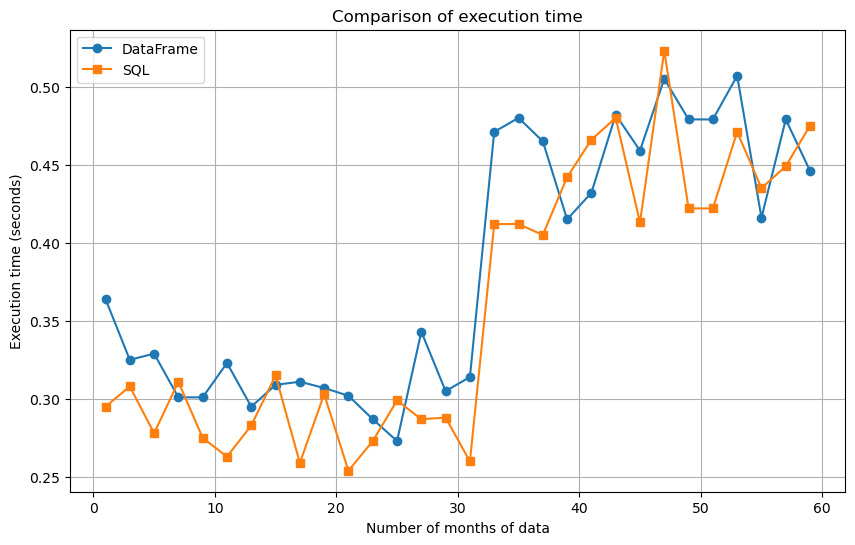

In [42]:
plt.figure(figsize=(10,6))

plt.plot(months, times_df, marker='o', label='DataFrame')
plt.plot(months, times_sql, marker='s', label='SQL')

plt.xlabel('Number of months of data')
plt.ylabel("Execution time (seconds)")
plt.title("Comparison of execution time")
plt.grid(True)
plt.legend()
plt.show()

**This chart shows that for up to 30 months of data, the execution time remains roughly constant around 0.25 seconds. After 32 months of data, the execution time nearly doubles and appears to continue increasing linearly with the amount of data.**

**The chart also shows that both methods have very similar execution times for the same amount of data.**

**Let's analyze this in more detail :**

In [43]:
months = [i for i in range(1, 60, 5)]
times_df = []
times_sql = []

for i in months:
    # Time DataFrame
    t0_df = time()
    dataFrame(i)
    times_df.append(np.round(time() - t0_df, 3))

    # Time SQL
    t0_sql = time()
    SQL(i)
    times_sql.append(np.round(time() - t0_sql, 3))

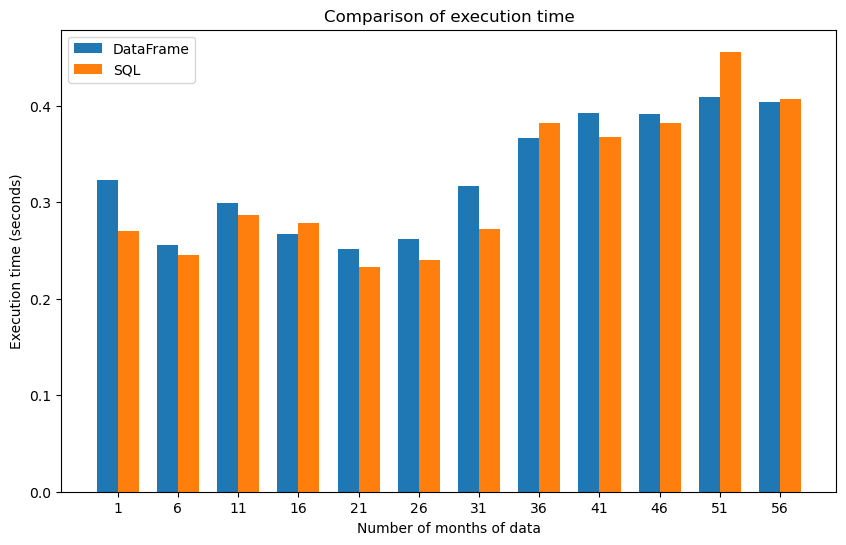

In [44]:
x = np.array([i for i in range(len(months))])
width = 0.35


fig = plt.subplots(figsize=(10,6))

plt.bar(x - width/2, times_df, width, label='DataFrame')
plt.bar(x + width/2, times_sql, width, label='SQL')


plt.xlabel('Number of months of data')
plt.ylabel("Execution time (seconds)")
plt.title("Comparison of execution time")
plt.xticks(x,months)
plt.legend()

plt.show()

**Let's calculate the average execution ratios**

In [45]:
ratios = np.array(times_sql) / np.array(times_df)

#Average of ratios
mean_ratio = np.mean(ratios)

print("Average ratio of execution times (SQL / DataFrame) :", mean_ratio)

Average ratio of execution times (SQL / DataFrame) : 0.9646168488869997


**The ratio is very close to 1, so we can conclude that, for this study, using DataFrames or SQL queries is almost equivalent.**

### E) Analysis of the speedup evolution with the number of processors

**Now, let's examine the effect of increasing the number of processors on processing speed.**

1  -->  0.49262237548828125
2  -->  0.47626082102457684
3  -->  0.44048269589742023
4  -->  0.4470802942911784


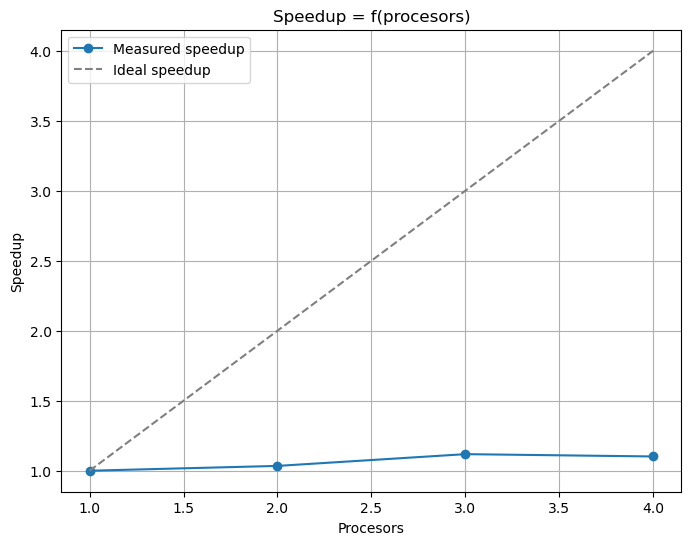

In [52]:

cores = [1, 2, 3, 4]  
runs = 3              
months = 60        
times = []

for core in cores:
    spark = SparkSession.builder.master('local[core]').getOrCreate()


    #Average over multiple runs due to high variability
    run_times = []
    for i in range(runs):
        t0 = time()
        dataFrame(months) 
        run_times.append(time() - t0)
    
    avg_time = np.mean(run_times)
    times.append(avg_time)
    
    print(core, " --> ", avg_time)

#Speedup
speedup = []
for i in range(len(times)):
    speedup.append(times[0]/times[i])

plt.figure(figsize=(8,6))
plt.plot(cores, speedup, 'o-', label='Measured speedup')
plt.plot(cores, cores, '--', color='gray', label='Ideal speedup')

plt.xlabel('Procesors')
plt.ylabel('Speedup')
plt.title('Speedup = f(procesors)')
plt.legend()
plt.grid(True)
plt.show()

**We can observe that the speedup remains almost constant despite the increase in the number of cores. The obtained trend therefore does not match the theoretically expected (linear) behavior. This can be explained by an insufficient volume of data, which does not allow full utilization of the parallelism offered by Spark.**

### Conclusion

**Overall, all methods lead to the same conclusion: the most frequent trips occur between the Upper East Side South and Upper East Side North zones in Manhattan during the years 2020 - 2022. In terms of performance, using DataFrames or Spark SQL yields equivalent results, both providing fast execution even when processing several years of data. In contrast, the RDD approach requires significantly more time and does not scale as efficiently with larger data volumes**

# Part 2 : Analysis of Tipping Behavior by Number of Passengers using DataFrames

## Introduction

This analysis investigates tipping behavior in taxi rides. We wanted to see if the number of passengers in a car affects the average tip percentage given at the end of the ride. By analyzing a large dataset of trips, we compared the average tips for groups of different sizes (specifically, rides with one to six passengers) to identify any clear patterns or differences.

## First implementation

We first load the data using the Parquet parser of Spark.

In [67]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.sql import functions as F

spark = SparkSession.builder.master('local[2]').getOrCreate()
df = spark.read.format("parquet").option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load("data/*.parquet")
print("Number of trips:",df.count())
df.printSchema()

Number of trips: 179807942
root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: double (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: double (nullable = true)
 |-- airport_fee: integer (nullable = true)



In the Spark UI, we can see that loading the data took 0.418 milliseconds.

In [61]:
df.select("PULocationID", "DOLocationID", "tip_amount", "passenger_count", "total_amount") \
    .filter(df["total_amount"] > 0) \
    .withColumn("tip_percent", (F.col("tip_amount") / F.col("total_amount") * 100)) \
    .groupBy("passenger_count") \
    .agg(F.avg("tip_percent").alias("avg_tip_percent")).orderBy(F.desc("avg_tip_percent")) \
    .show()

+---------------+------------------+
|passenger_count|   avg_tip_percent|
+---------------+------------------+
|           NULL|60.063419331989465|
|          112.0|16.666666666666664|
|           96.0|13.043478260869568|
|            1.0| 11.40766087844835|
|            5.0|11.352980006859077|
|            6.0|11.309975849139262|
|            2.0|11.118978531585393|
|            0.0|11.036427380815713|
|            3.0|    10.88123160406|
|            4.0|10.170780710575505|
|            8.0| 9.690808621531673|
|            9.0| 9.566487658538772|
|            7.0| 9.419216760568446|
+---------------+------------------+



Spark UI shows that this operation took 11 seconds.

This first analysis of the tips is not accurate because of incorrect data. Some trips have no passenger number (NULL) or impossible numbers, like 96 or 112. These strange figures made the calculation of the average tip wrong.

## Second implementation

To fix this and get more accurate results, we filter the data to only keep rides with a normal number of passengers, specifically between 1 and 6. This removes the unrealistic trips. Then, we count the total number of rides for each passenger group. We then decided to only keep groups that had more than 1,000 rides. This makes sure our average is based on a large amount of data, not just a few trips.

df.select("PULocationID", "DOLocationID", "tip_amount", "passenger_count", "total_amount") \
    .filter(df["total_amount"] > 0) \
    .withColumn("tip_percent", (F.col("tip_amount") / F.col("total_amount") * 100)) \
    .filter(F.col("passenger_count").between(1, 6)) \
    .groupBy("passenger_count") \
    .agg(F.count("*").alias("nb_courses"),F.avg("tip_percent").alias("avg_tip_percent")) \
    .filter(F.col("nb_courses") > 1000) \
    .orderBy(F.desc("avg_tip_percent")) \
    .show()

Spark UI shows that this operation also took 11 seconds. This shows that the complexity of the operation is far from being the bottleneck of the processing time, instead it is the data size.

## Conclusion

Based on the analysis, the number of passengers has a small but clear effect on tipping habits.

Our results show that single passengers (1.0) gave the highest average tips, at 11.41%. The lowest tips came from groups of four passengers (4.0), who tipped an average of 10.17% of total amount. While the differences are not massive, the data clearly indicates that traveling alone or in a group of four impacts the final tip percentage.

Spark's DataFrame allowed us to handle over 179 million rides for this analysis. We chained commands like .select(), .filter(), and .groupBy() to create a clear and logical "recipe" for our task. This approach is easy to read and efficient, allowing Spark to handle all the difficult work of processing such a huge volume of data.


# Part 3 : Analysis of NYC Taxi Data using RDDs

## Introduction 

This part demonstrates the use of Apache Spark RDDs (Resilient Distributed Datasets) for analyzing NYC taxi trip data from 2023. RDD are a low level Spark API, offering fine-grained control over distributed data processing through map-reduce operations.

## 1. Setup

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkContext
from operator import add # Useful for some RDD operations like reduce
import time # Necessary to measure execution time

# Initialization of the SparkSession and SparkContext
# The two lines of memory config to avoid kernel crash
spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Analyse Taxis NYC RDD Simple v3 - 1 Month") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "8g") \
    .getOrCreate()

sc = spark.sparkContext

# Display configuration information
print(f"Spark Version: {spark.version}")

Spark Version: 4.0.1


### Launch Verification

In [2]:
!pip install psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 8.2 gigabytes of available RAM



In [3]:
spark.sparkContext.defaultParallelism

16

## 2. Data Loading

In [4]:
# Path to load all Parquet files from 2023
# Warning, do not put the January file yellow_tripdata_2023-01.parquet in the taxi folder because it has a different schema than the others.
parquet_path_all = "taxi/yellow_tripdata_2023-*.parquet"

print(f"\nLoading months of data from: {parquet_path_all}")

try:
    # 1. Load as DataFrame (Spark reads Parquet optimally)
    df_taxi = spark.read.parquet(parquet_path_all)
    print("Data loading in DataFrame completed (11 months).")

    # 2. Display schema and preview for confirmation
    print(f"\nTotal number of records (Action .count() recommended only for testing on 1 month or after a filter): {df_taxi.count():,}")
    print("\nData Schema:")
    df_taxi.printSchema()

    # 3. Convert to RDD for the RR analysis
    taxi_rdd = df_taxi.rdd
    print("\nDataFrame converted to RDD.")

    # 4. Cache (to speed up repeated RDD actions)
    taxi_rdd.cache()
    print(f"RDD cached. Number of partitions: {taxi_rdd.getNumPartitions()}")

except Exception as e:
    print(f"\nERROR: Problem loading data from 12 months.")
    print(e)
    # Stop Spark in case of a loading error
    spark.stop()
    raise SystemExit("Shutdown due to data loading error.")


Loading months of data from: taxi/yellow_tripdata_2023-*.parquet
Data loading in DataFrame completed (11 months).

Total number of records (Action .count() recommended only for testing on 1 month or after a filter): 35,243,460

Data Schema:
root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: integer (nullable = true)
 |-- DOLocationID: integer (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: doub

## 3. Simple Analysis with RDD

In [5]:
# This first very simple analysis allows us to check that the data is fully loaded and the spark context works as expected.
if 'taxi_rdd' in locals(): # Check if RDD has been created

    # ### Study 1: Count total number of trips (Action: count)
    print("\n--- RDD Study: Total number of trips ---")
    start_time = time.time()
    try:
        # The .count() action forces reading and returns the total number of elements.
        total_trajets = taxi_rdd.count()
        end_time = time.time()
        print(f"Total number of trips in the sample (1 month): {total_trajets:,}")
        print(f"Computation time: {end_time - start_time:.2f} seconds")
    except Exception as e:
        print(f"Study 1 failed (RDD.count): {e}")


--- RDD Study: Total number of trips ---
Total number of trips in the sample (1 month): 35,243,460
Computation time: 70.77 seconds


## 4. Analysis of Pickup Zones

In [6]:
# We can now proceed to a more complex analysis, and use the map reduce model we learned, to count and order pickup locations. 
if 'taxi_rdd' in locals(): # Ensure that the RDD is available

    # --- RDD Study: Top 10 pickup zones (PULocationID) ---
    print("\n--- RDD Study: Top 10 pickup zones (PULocationID) ---")
    start_time_rdd = time.time()

    try:
        # 1. Map: (PULocationID, 1) - Extract the ID and assign a counter of 1
        # Columns are accessible by name in the Row RDD.
        rdd_counts = taxi_rdd.map(lambda row: (row['PULocationID'], 1))

        # 2. ReduceByKey: Aggregate the number of trips by PULocationID (sum the '1's)
        rdd_reduced = rdd_counts.reduceByKey(add)

        # 3. Action (TakeOrdered): Get the 10 results with the highest value (count).
        # First sort by count (element[1]) in descending order (negative).
        # The result is a Python list [ (PULocationID, count), ... ]
        top_10_locations = rdd_reduced.takeOrdered(10, key=lambda x: -x[1])

        end_time_rdd = time.time()
        time_rdd = end_time_rdd - start_time_rdd

        # Display results
        print(f"Computation time: {time_rdd:.2f} seconds")
        print("\nTop 10 pickup zones:")
        print("| Zone ID | Number of Trips |")
        print("|---|---|\n")
        for location_id, count in top_10_locations:
            print(f"| {location_id:^7} | {count:^15,} |")

    except Exception as e:
        print(f"Study 2 failed (RDD.map/reduceByKey): {e}")


--- RDD Study: Top 10 pickup zones (PULocationID) ---
Computation time: 36.32 seconds

Top 10 pickup zones:
| Zone ID | Number of Trips |
|---|---|

|   132   |    1,832,274    |
|   237   |    1,643,721    |
|   161   |    1,630,624    |
|   236   |    1,458,193    |
|   162   |    1,248,419    |
|   138   |    1,216,071    |
|   186   |    1,195,886    |
|   230   |    1,171,690    |
|   142   |    1,155,796    |
|   170   |    1,043,327    |


## 5. Analysis of Average Speed by Hour of Day

In [6]:
from datetime import timedelta # Necessary for time calculations

if 'taxi_rdd' in locals(): # Ensure that the RDD is available

    
    print("\n--- RDD Study: Average speed by hour of day ---")
    start_time_rdd_complex = time.time()

    try:
        # A helper function to extract hour and calculate duration in seconds
        def extract_hour_and_duration(row):
            pickup_time = row['tpep_pickup_datetime']
            dropoff_time = row['tpep_dropoff_datetime']

            # Ensure that values are not null and dropoff is after pickup
            if pickup_time and dropoff_time and dropoff_time > pickup_time:
                trip_duration_seconds = (dropoff_time - pickup_time).total_seconds()
                # Filter unrealistic durations (e.g., more than 24h) and null durations
                if trip_duration_seconds > 60 and trip_duration_seconds < (24 * 3600):
                    # Key: Hour of pickup (0-23)
                    hour = pickup_time.hour
                    # Values: (Distance, Duration in hours)
                    trip_distance = row['trip_distance']
                    trip_duration_hours = trip_duration_seconds / 3600.0
                    return (hour, (trip_distance, trip_duration_hours))
            return None # Ignore invalid rows

        # 1 Map: (Hour, (Distance, Duration in hours)) + Filtering
        rdd_distance_duration = taxi_rdd.map(extract_hour_and_duration).filter(lambda x: x is not None)

        # 2 ReduceByKey: (Hour, (Total Distance, Total Duration))
        # Aggregation function: (dist1, dur1) + (dist2, dur2) = (dist1+dist2, dur1+dur2)
        rdd_totals = rdd_distance_duration.reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1]))

        # 3 Map: (Hour, Average Speed) where Speed = TotalDistance / TotalDuration
        rdd_avg_speed = rdd_totals.map(lambda x: (x[0], x[1][0] / x[1][1])) # x[0] = Hour, x[1][0] = Total Dist, x[1][1] = Total Duration

        # 4 Action (Collect) and Sort: Retrieve result and sort by hour
        avg_speed_by_hour = sorted(rdd_avg_speed.collect(), key=lambda x: x[0])

        end_time_rdd_complex = time.time()
        time_rdd_complex = end_time_rdd_complex - start_time_rdd_complex

        # We display results
        print(f"Computation time: {time_rdd_complex:.2f} seconds")
        print("\nAverage Speed (mph) by Hour of Day:")
        print("| Hour | Average Speed (mph) |")
        print("|---|---|\n")
        for hour, avg_speed in avg_speed_by_hour:
            print(f"| {hour:^5} | {avg_speed:^19.2f} |")

    except Exception as e:
        print(f"Complex RDD Study failed: {e}")


--- RDD Study: Average speed by hour of day ---
Computation time: 46.37 seconds

Average Speed (mph) by Hour of Day:
| Hour | Average Speed (mph) |
|---|---|

|   0   |        15.36        |
|   1   |        14.63        |
|   2   |        19.74        |
|   3   |        20.71        |
|   4   |        41.38        |
|   5   |        41.32        |
|   6   |        32.70        |
|   7   |        22.63        |
|   8   |        15.67        |
|   9   |        15.03        |
|  10   |        12.16        |
|  11   |        12.15        |
|  12   |        11.95        |
|  13   |        12.63        |
|  14   |        12.07        |
|  15   |        12.90        |
|  16   |        11.03        |
|  17   |        12.01        |
|  18   |        11.94        |
|  19   |        13.74        |
|  20   |        13.53        |
|  21   |        14.65        |
|  22   |        15.12        |
|  23   |        15.45        |


## Conclusion 

The average speed analysis by hour of day reveals coherent and expected patterns in NYC taxi traffic. The results show higher average speeds during late-night and early-morning hours (approximately midnight to 5 AM) when the city is quieter with less traffic congestion. Conversely, lower average speeds are observed during typical rush hours and busy daytime periods when traffic density increases. This pattern aligns with real-world expectations: taxis can travel faster on less congested streets during off-peak hours. The RDD-based implementation successfully processed millions of trip records, using the map-reduce paradigm we saw in class.